# AnoGAN
GANの以上検出モデルの論文をまとめたスライド  
https://www.slideshare.net/Koichirotamura2/gan-anogan?ref=https://note.com/koichirot11/n/n24151f3c7af8  
AnoGANの解説と実装  
https://qiita.com/NakaokaRei/items/231ec4efe42dfe79d1ff  
GANによる異常検出の有名どころをまとめた記事  
https://note.com/koichirot11/n/n24151f3c7af8

In [29]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generatorの実装

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


# Discriminatorの実装

In [11]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報 torch.Size([1, 512, 4, 4])
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last(out)

        return out, feature

In [12]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)
G = Generator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)

tensor([[[[0.5021]]]], grad_fn=<SigmoidBackward>)
torch.Size([1, 8192])


# DataLoaderの作成

In [13]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [14]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# GANを学習させる

In [16]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [21]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
        log_epoch = {'epoch' : epoch+1,
                     'g_loss' : epoch_g_loss/batch_size,
                     'd_loss' : epoch_d_loss/batch_size}
        logs.append(log_epoch)
        df = pd.DataFrame(logs) 
        df.to_csv('mnist_log_output.csv')  

    
    print("総イテレーション回数:", iteration)

    return G, D


In [23]:
# 学習・検証を実行する
# 8分ほどかかる
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/300
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1102 ||Epoch_G_Loss:0.2179
timer:  0.3665 sec.
-------------
Epoch 1/300
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1120 ||Epoch_G_Loss:0.1591
timer:  0.3611 sec.
-------------
Epoch 2/300
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1021 ||Epoch_G_Loss:0.2078
timer:  0.3613 sec.
-------------
Epoch 3/300
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1169 ||Epoch_G_Loss:0.1410
timer:  0.3615 sec.
-------------
Epoch 4/300
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1172 ||Epoch_G_Loss:0.1681
timer:  0.3620 sec.
-------------
Epoch 5/300
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.1113 ||Epoch_G_Loss:0.1531
timer:  0.3610 sec.
-------------
Epoch 6/300
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.1213 ||Epoch_G_Loss:0.1352
timer:  0.3615 sec.
-------------
Epoch 7/300
-------------


-------------
epoch 60 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.2764
timer:  0.3662 sec.
-------------
Epoch 61/300
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.0729 ||Epoch_G_Loss:0.2268
timer:  0.3667 sec.
-------------
Epoch 62/300
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.0762 ||Epoch_G_Loss:0.2373
timer:  0.3658 sec.
-------------
Epoch 63/300
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.0646 ||Epoch_G_Loss:0.2424
timer:  0.3657 sec.
-------------
Epoch 64/300
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.0775 ||Epoch_G_Loss:0.2535
timer:  0.3662 sec.
-------------
Epoch 65/300
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.0647 ||Epoch_G_Loss:0.2374
timer:  0.3657 sec.
-------------
Epoch 66/300
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.0697 ||Epoch_G_Loss:0.2261
timer:  0.3661 sec.
-------------
Epoch 67/300
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0449 ||Epoch_G_Loss:0.3648
timer:  0.3688 sec.
-------------
Epoch 121/300
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0369 ||Epoch_G_Loss:0.3700
timer:  0.3703 sec.
-------------
Epoch 122/300
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0460 ||Epoch_G_Loss:0.3996
timer:  0.3697 sec.
-------------
Epoch 123/300
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0505 ||Epoch_G_Loss:0.3169
timer:  0.3707 sec.
-------------
Epoch 124/300
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0496 ||Epoch_G_Loss:0.3739
timer:  0.3687 sec.
-------------
Epoch 125/300
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0226 ||Epoch_G_Loss:0.3891
timer:  0.3688 sec.
-------------
Epoch 126/300
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.3665
timer:  0.3699 sec.
-------------
Epoch 127/300
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0271 ||Epoch_G_Loss:0.5347
timer:  0.3710 sec.
-------------
Epoch 180/300
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0206 ||Epoch_G_Loss:0.6017
timer:  0.3704 sec.
-------------
Epoch 181/300
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0307 ||Epoch_G_Loss:0.4374
timer:  0.3720 sec.
-------------
Epoch 182/300
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0177 ||Epoch_G_Loss:0.5495
timer:  0.3712 sec.
-------------
Epoch 183/300
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0282 ||Epoch_G_Loss:0.5659
timer:  0.3706 sec.
-------------
Epoch 184/300
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0196 ||Epoch_G_Loss:0.6018
timer:  0.3712 sec.
-------------
Epoch 185/300
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0220 ||Epoch_G_Loss:0.5483
timer:  0.3713 sec.
-------------
Epoch 186/300
-------------
（train）
-------------
epoch 186 || 

-------------
epoch 238 || Epoch_D_Loss:0.0067 ||Epoch_G_Loss:0.6591
timer:  0.3754 sec.
-------------
Epoch 239/300
-------------
（train）
-------------
epoch 239 || Epoch_D_Loss:0.0036 ||Epoch_G_Loss:0.8016
timer:  0.3854 sec.
-------------
Epoch 240/300
-------------
（train）
-------------
epoch 240 || Epoch_D_Loss:0.0368 ||Epoch_G_Loss:0.5173
timer:  0.3985 sec.
-------------
Epoch 241/300
-------------
（train）
-------------
epoch 241 || Epoch_D_Loss:0.0101 ||Epoch_G_Loss:0.6391
timer:  0.3905 sec.
-------------
Epoch 242/300
-------------
（train）
-------------
epoch 242 || Epoch_D_Loss:0.0028 ||Epoch_G_Loss:0.7517
timer:  0.3750 sec.
-------------
Epoch 243/300
-------------
（train）
-------------
epoch 243 || Epoch_D_Loss:0.0434 ||Epoch_G_Loss:0.6763
timer:  0.3717 sec.
-------------
Epoch 244/300
-------------
（train）
-------------
epoch 244 || Epoch_D_Loss:0.0267 ||Epoch_G_Loss:0.5224
timer:  0.3824 sec.
-------------
Epoch 245/300
-------------
（train）
-------------
epoch 245 || 

-------------
epoch 297 || Epoch_D_Loss:0.0035 ||Epoch_G_Loss:0.7196
timer:  0.3751 sec.
-------------
Epoch 298/300
-------------
（train）
-------------
epoch 298 || Epoch_D_Loss:0.0087 ||Epoch_G_Loss:0.8674
timer:  0.3708 sec.
-------------
Epoch 299/300
-------------
（train）
-------------
epoch 299 || Epoch_D_Loss:0.0364 ||Epoch_G_Loss:0.8495
timer:  0.3731 sec.
総イテレーション回数: 2101


# AnoGANの本体

In [39]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):
    
    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x - fake_img) # (batch_size, channel, height, width)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1) # (batch_size, channel*height*width)
    residual_loss = torch.sum(residual_loss, dim=1) # (batch, sum)
    
    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量を取り出す
    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    
    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature - G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    # ミニバッチごとに2種類の損失を足し算する
    loss_epoch = (1 - Lambda) * residual_loss + Lambda * discrimination_loss
    
    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_epoch)
    
    return total_loss, loss_epoch, residual_loss

# テスト用Dataloader 

In [27]:
def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/test/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


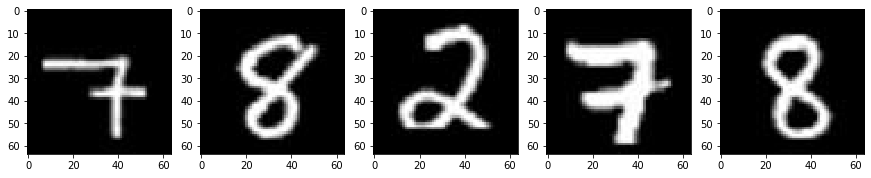

In [32]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
images = next(batch_iterator)  

# 1番目のミニバッチを取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

# 学習検証

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 異常検知したい画像
x = images[0:5] # (batch_size=5, channel=1, 64, 64)
x = x.to(device)

# 異常検知したい画像を生成するための、初期乱数
z = torch.randn(5, 20).to(device) # batch_size=5, z_dim=20
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることが可能なように、requires_gradをTrueに設定
z.requires_grad = True

# 変数zを更新できるように、zの最適化関数を求める
z_optimizer = torch.optim.Adam([z], lr=1e-3)

logs = []
# zを求める
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, loss_epoch, _ = Anomaly_score(x, fake_img, D, Lambda=0.1)
    
    z_optimizer.zero_grad() # 勾配の初期化
    loss.backward() # バックプロパゲーション
    z_optimizer.step() # 重みの更新

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))
        
    if epoch % 100 == 0:
        log_epoch = {'epoch' : epoch+1,
                                 'total_loss' : loss.item(),
                                 '1' : loss_epoch[0].item(),
                                 '2' : loss_epoch[1].item(),
                                 '3' : loss_epoch[2].item(),
                                 '4' : loss_epoch[3].item(),
                                 '5' : loss_epoch[4].item()}
        logs.append(log_epoch)
df = pd.DataFrame(logs) 

epoch 0 || loss_total:6767 
epoch 1000 || loss_total:4777 
epoch 2000 || loss_total:3388 
epoch 3000 || loss_total:2662 
epoch 4000 || loss_total:2494 
epoch 5000 || loss_total:2421 


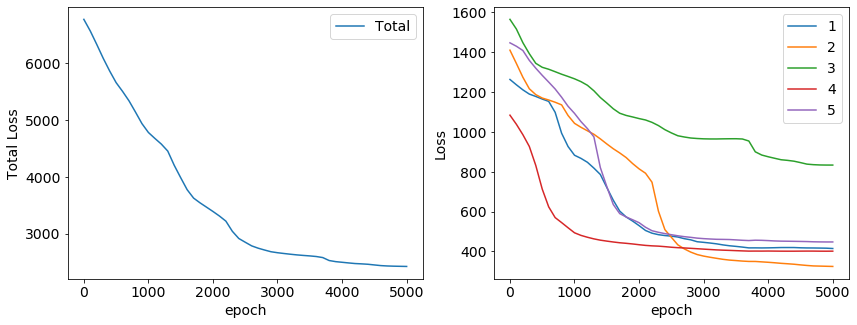

In [93]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(df['epoch'], df['total_loss'], '-', label='Total')
plt.xlabel('epoch')
plt.ylabel('Total Loss')
plt.legend()

plt.subplot(1,2,2)
for i in range(5):
    plt.plot(df['epoch'], df.iloc[:,i+2], label=str(i+1))

plt.xlabel('epoch')
plt.ylabel('Loss')
    
plt.legend()
plt.show()

total loss: [412. 326. 837. 403. 446.]


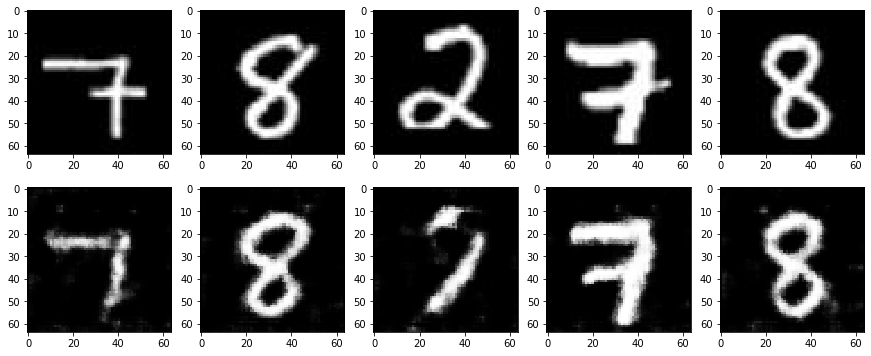

In [52]:
# 画像を生成
fake_img = G_update(z)

# 損失を求める
loss, loss_epoch, residual_loss_epoch = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

loss_epoch = loss_epoch.cpu().detach().numpy()
print('total loss:', np.round(loss_epoch, 0))

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')

torch.Size([5, 20, 1, 1])